In [1]:
# notebooks/03_LSTMPipeline.ipynb
# End-to-end deep learning pipeline for ERA5 precipitation prediction using LSTM model

# LOAD LIBRARIES

In [17]:
# import libraries to run notebook

import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

from src.train import train_lstm_model, print_results
from src.evaluate import *
from src.deeplearning_models import create_history_windows_torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
# import optuna
import os

# SET UP RANDOM SEED, DATA PATH & PARAMETERS

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(88)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cpu


In [4]:
processed_folder = "../data"
data_path = f"{processed_folder}/era5_1960to2020_17feats_processed.npz"
print(data_path)

../data/era5_1960to2020_17feats_processed.npz


# TRAIN LSTM MODEL | T = 7, horizon = 3

In [5]:
# Set up parameters for training
# Update these to test different model structures or history windows
T = 7
horizon = 3
hidden_dim = 64
num_layers = 1
dropout = 0.0                     # apply dropout (0.2–0.5)
epochs = 250
batch_size = 64                   # 32, 64, and 128
lr = 1e-4                         # 1e-4
device = DEVICE
patience = 15                     # early stopping
weight_decay = 1e-5               # l2 regularization
loss_type = 'rmse'                # loss metric used for training
quantile_q = 0.5

In [6]:
# Run LSTM model training
set_seed(99)

results = train_lstm_model(
    data_path=data_path,
    T=T,
    horizon=horizon,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    device=device,
    patience=patience,
    weight_decay=weight_decay,
    loss_type=loss_type,
    quantile_q=quantile_q
)

Epoch 1/250 | Train Loss: 8.529406808122246 | Val RMSE: 9.087228229833869
Epoch 10/250 | Train Loss: 7.969278372335045 | Val RMSE: 8.83645133580296
Epoch 20/250 | Train Loss: 7.950513590371629 | Val RMSE: 8.813148711255486
Epoch 30/250 | Train Loss: 7.936947650198777 | Val RMSE: 8.789288402366198
Epoch 40/250 | Train Loss: 7.928091726648014 | Val RMSE: 8.771916895178185
Epoch 50/250 | Train Loss: 7.9210837948987525 | Val RMSE: 8.76785036086372
Epoch 60/250 | Train Loss: 7.918232361024987 | Val RMSE: 8.768464107312868
Early stopping at epoch 66
Extreme events > 95th percentile -> RMSE: 28.813817977905273, MAE: 25.86933135986328
Total extreme events: 37, Predicted extreme events: 0


In [7]:
# Show results of model training on test data
print_results(results)

Test Data Results:
------------------
LSTM --> RMSE = 7.828487060458216, MAE = 4.663435935974121


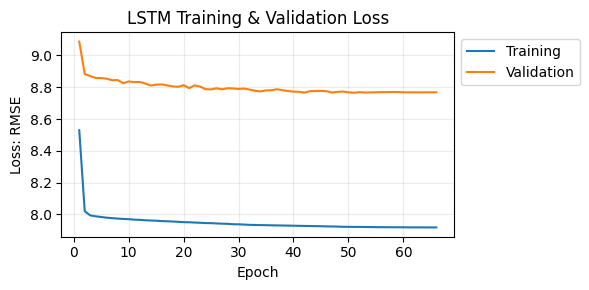

In [8]:
# Plotting training results
train_loss=results['LSTM']["train_loss"]
val_loss=results['LSTM']["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel(f"Loss: {results['LSTM']['loss_type']}")
plt.title("LSTM Training & Validation Loss")
plt.grid(alpha=0.25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

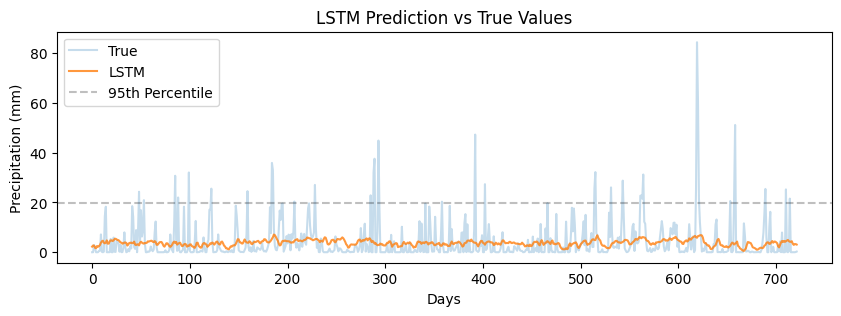

In [9]:
# Plotting test prediction results vs. true test data
y_true = np.load(data_path)['y_test']
threshold = np.percentile(y_true, 95)

y_pred_lstm = results["LSTM"]["y_pred"]
y_true_aligned = y_true[T - 1 + horizon : T - 1 + horizon + len(y_pred_lstm)]

plt.figure(figsize=(10,3))
plt.plot(y_true_aligned, alpha=0.25, label="True")
plt.plot(y_pred_lstm, alpha=0.8, label="LSTM")
plt.axhline(y=threshold, color='black', linestyle='--', label='95th Percentile', alpha=0.25)
plt.title("LSTM Prediction vs True Values")
plt.xlabel("Days")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()

# TRAIN LSTM MODEL | T = 30, horizon = 3

In [11]:
# 'rmse', 'mae', 'huber', 'quantile', 'log_mse'
# Set up parameters for training
# Update these to test different model structures or history windows
# Trying different hyperparameters

T = 30
horizon = 3
hidden_dim = 128
num_layers = 2
dropout = 0.3                     # apply dropout (0.2–0.5)
epochs = 250
batch_size = 64                   # 32, 64, and 128
lr = 1e-4                         # 1e-4
device = DEVICE
patience = 30                     # early stopping
weight_decay = 1e-5               # l2 regularization
loss_type = 'rmse'                # loss metric used for training
quantile_q = 0.5

In [12]:
# Run LSTM model training
set_seed(88)

results = train_lstm_model(
    data_path=data_path,
    T=T,
    horizon=horizon,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    device=device,
    patience=patience,
    weight_decay=weight_decay,
    loss_type=loss_type,
    quantile_q=quantile_q
)

Epoch 1/250 | Train Loss: 8.184987871512124 | Val RMSE: 8.859195975977725
Epoch 10/250 | Train Loss: 7.970410533463315 | Val RMSE: 8.793841184708844
Epoch 20/250 | Train Loss: 7.936597050592869 | Val RMSE: 8.771743859502063
Epoch 30/250 | Train Loss: 7.893912024907961 | Val RMSE: 8.71036947566819
Epoch 40/250 | Train Loss: 7.828079289984428 | Val RMSE: 8.77079585770585
Epoch 50/250 | Train Loss: 7.783692371645535 | Val RMSE: 8.789520025163336
Early stopping at epoch 60
Extreme events > 95th percentile -> RMSE: 29.180057525634766, MAE: 26.169891357421875
Total extreme events: 35, Predicted extreme events: 0


In [13]:
# Show results of model training on test data
print_results(results)

Test Data Results:
------------------
LSTM --> RMSE = 7.870993185229157, MAE = 4.624552249908447


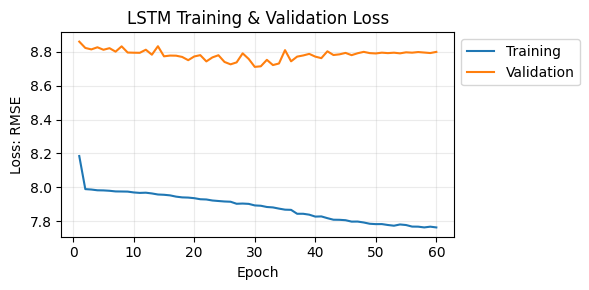

In [14]:
# Plotting training results
train_loss=results['LSTM']["train_loss"]
val_loss=results['LSTM']["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel(f"Loss: {results['LSTM']['loss_type']}")
plt.title("LSTM Training & Validation Loss")
plt.grid(alpha=0.25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

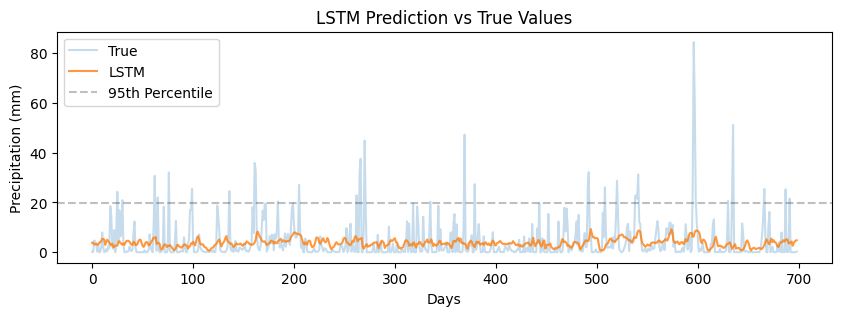

In [15]:
# Plotting test prediction results vs. true test data
y_true = np.load(data_path)['y_test']
threshold = np.percentile(y_true, 95)

y_pred_lstm = results["LSTM"]["y_pred"]
y_true_aligned = y_true[T - 1 + horizon : T - 1 + horizon + len(y_pred_lstm)]

plt.figure(figsize=(10,3))
plt.plot(y_true_aligned, alpha=0.25, label="True")
plt.plot(y_pred_lstm, alpha=0.8, label="LSTM")
plt.axhline(y=threshold, color='black', linestyle='--', label='95th Percentile', alpha=0.25)
plt.title("LSTM Prediction vs True Values")
plt.xlabel("Days")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()

In [16]:
# Evaluating results on extreme weather events
for model_name, result in results.items():
    y_pred = result['y_pred']
    name = model_name.replace("_", " ").upper()
    print(f"\nEvaluating extreme events for {name} model:")
    evaluate_extreme_events(y_true, y_pred, percentile=95)
    print("-"*50)


Evaluating extreme events for LSTM model:
Extreme events > 95th percentile -> RMSE: 29.666057586669922, MAE: 26.459867477416992
Total extreme events: 35, Predicted extreme events: 0
--------------------------------------------------


# HYPERPARAMETER TUNING

In [ ]:
# def set_seed(seed: int = 42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(99)
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# processed_folder = "../data"
# data_path = f"{processed_folder}/era5_processed.npz"

# def objective(trial):

#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
#     num_layers = trial.suggest_int('num_layers', 1, 3)
#     hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
#     dropout = trial.suggest_float('dropout', 0.0, 0.5)
#     lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
#     T = trial.suggest_int('T', 7, 56)
    
#     # T = 7
#     horizon = 3

#     results = train_lstm_model(
#         data_path=data_path,
#         T=T,
#         horizon=horizon,
#         hidden_dim=hidden_dim,
#         num_layers=num_layers,
#         dropout=dropout,
#         epochs=50,       
#         batch_size=batch_size,
#         lr=lr,
#         device=DEVICE,
#         patience=10
#     )
    
#     val_rmse = results['LSTM']['val_rmse'][-1]
#     return val_rmse

# # study = optuna.create_study(direction='minimize')
# # study.optimize(objective, n_trials=30)

# # print("Best hyperparameters found:")
# # print(study.best_params)

In [ ]:
# Best hyperparameters found:
# {'batch_size': 64, 'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.30085541641613639, 'lr': 0.0007489689785118738}